In [1]:
library(AppliedPredictiveModeling)
data(schedulingData)

In [2]:
str(schedulingData)

'data.frame':	4331 obs. of  8 variables:
 $ Protocol   : Factor w/ 14 levels "A","C","D","E",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Compounds  : num  997 97 101 93 100 100 105 98 101 95 ...
 $ InputFields: num  137 103 75 76 82 82 88 95 91 92 ...
 $ Iterations : num  20 20 10 20 20 20 20 20 20 20 ...
 $ NumPending : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Hour       : num  14 13.8 13.8 10.1 10.4 ...
 $ Day        : Factor w/ 7 levels "Mon","Tue","Wed",..: 2 2 4 5 5 3 5 5 5 3 ...
 $ Class      : Factor w/ 4 levels "VF","F","M","L": 2 1 1 1 1 1 1 1 1 1 ...


In [4]:
#missing value
any(is.na(schedulingData))

[1] FALSE

In [3]:
predictors <- names(schedulingData[names(schedulingData)!="Class"])

In [8]:
library(Hmisc)
describe(schedulingData)

schedulingData 

 8  Variables      4331  Observations
--------------------------------------------------------------------------------
Protocol 
       n  missing distinct 
    4331        0       14 
                                                                            
Value          A     C     D     E     F     G     H     I     J     K     L
Frequency     94   160   149    96   170   155   321   381   989     6   242
Proportion 0.022 0.037 0.034 0.022 0.039 0.036 0.074 0.088 0.228 0.001 0.056
                            
Value          M     N     O
Frequency    451   536   581
Proportion 0.104 0.124 0.134
--------------------------------------------------------------------------------
Compounds 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    4331        0      858        1    497.7    650.5       27       37 
     .25      .50      .75      .90      .95 
      98      226      448      967     2512 

lowest :    20    21    22    23    24, hig

> 在过去的两年，HPC环境中的一些硬件发生变更。结果是，同样的两个作业在两个不同年份的硬件上会产生两个不同的执行时间。这会膨胀执行时间的内在变化，并潜在地导致错误标注观测类的标签。然而在分析中没有办法来处理这类误差，任何对执行时间分类的模型都应该随着时间的推移重新审视

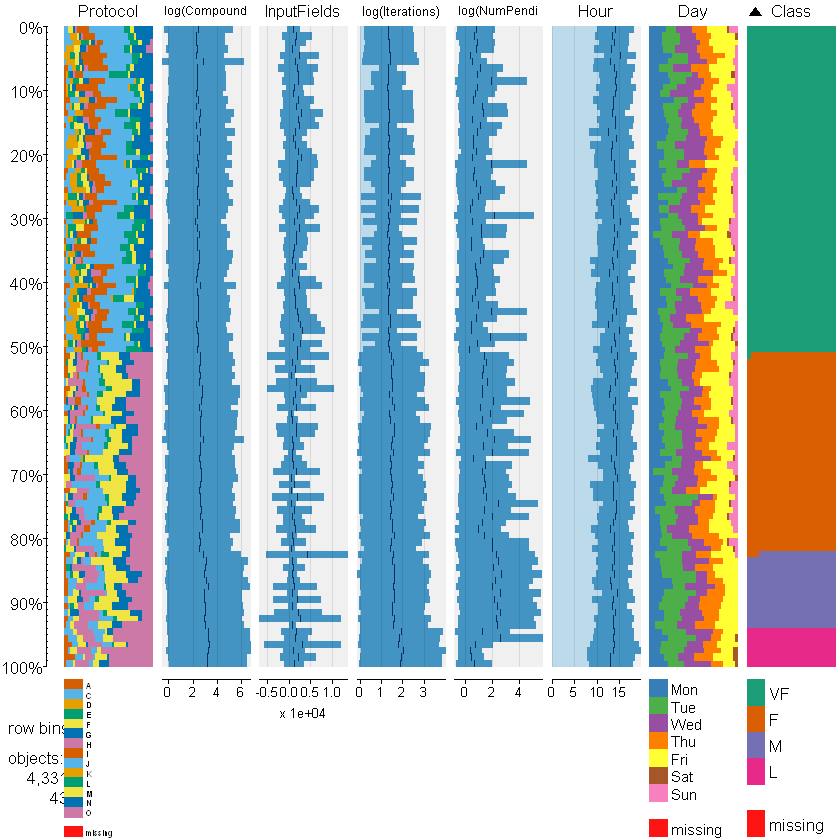

In [11]:
# https://cran.r-project.org/web/packages/tabplot/vignettes/tabplot-vignette.html
options(warn = -1)
library(tabplot)
tableplot(schedulingData,sortCol = Class,decreasing = F)

> 可以看到 
- 化合物数量大的作业更倾向于长时间或适中的执行时间；
- 很多中等长度的作业提交时作业挂起的数量很高。然而，在执行时间长的作业上这种趋势不会重现。正因为如此，提前确认这个观察结果并判断它是否是特定数据集的一个偶然现象至关重要。
- 当迭代次数较高，作业的执行时间相对较长。

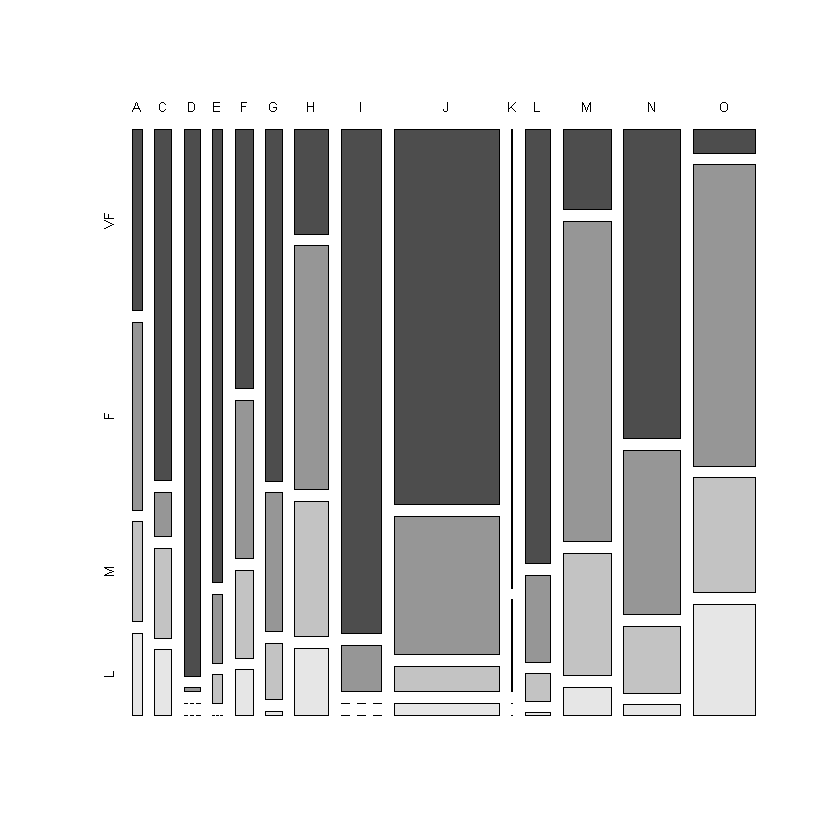

In [8]:
mosaicplot(table(schedulingData$Protocol,schedulingData$Class),
           main="",color = T)

> 图中，(横向)箱子的宽度表示协议运行的作业数，协议J运行做多，协议K运行最少；(纵向) 协议D比较容易被快速执行。

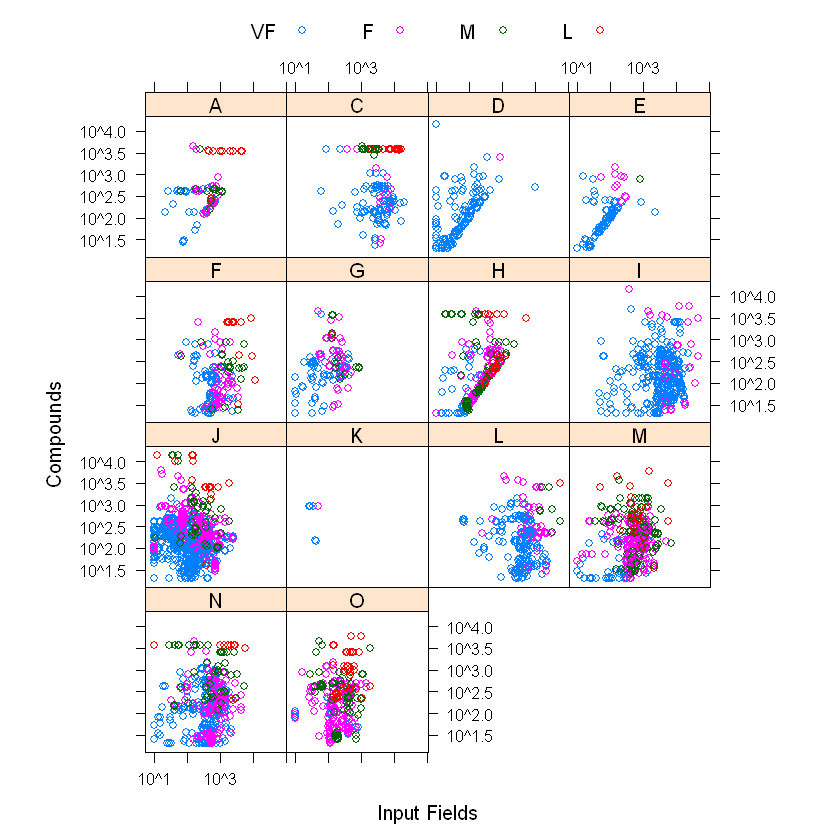

In [9]:
library(lattice)
xyplot(Compounds ~ InputFields|Protocol,
       data = schedulingData,
       scales = list(x = list(log = 10), y = list(log = 10)),
       groups = Class,
       xlab = "Input Fields",
       auto.key = list(columns = 4),
       aspect = 1,
       as.table = TRUE)

In [5]:
str(schedulingData)

'data.frame':	4331 obs. of  8 variables:
 $ Protocol   : Factor w/ 14 levels "A","C","D","E",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Compounds  : num  997 97 101 93 100 100 105 98 101 95 ...
 $ InputFields: num  137 103 75 76 82 82 88 95 91 92 ...
 $ Iterations : num  20 20 10 20 20 20 20 20 20 20 ...
 $ NumPending : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Hour       : num  14 13.8 13.8 10.1 10.4 ...
 $ Day        : Factor w/ 7 levels "Mon","Tue","Wed",..: 2 2 4 5 5 3 5 5 5 3 ...
 $ Class      : Factor w/ 4 levels "VF","F","M","L": 2 1 1 1 1 1 1 1 1 1 ...


In [11]:
#skewness
library(e1071)
apply(schedulingData[,c(2:6)], 2, skewness)

Compounds InputFields  Iterations  NumPending        Hour 
   6.565957    5.867573    3.935457    9.714598   -0.545493

In [5]:
# handling  severe skewness
schedulingData$NumPending <- schedulingData$NumPending+1

`Section 17.1 Data Splitting and Model Strategy`

In [6]:
library(caret)
trn_id <- createDataPartition(schedulingData$Class,p=0.8,list=F)
trn <- schedulingData[trn_id,]
vld <- schedulingData[-trn_id,]

Loading required package: lattice
Loading required package: ggplot2


In [7]:
modForm <- as.formula(Class~Protocol + log10(Compounds) +
                     log10(InputFields) + log10(Iterations) + log(NumPending) + Hour + Day)

modForm2 <- as.formula(Class ~ (Protocol + log10(Compounds) +
                                log10(InputFields)+ log10(Iterations) +
                                log10(NumPending) + Hour + Day)^2)

In [8]:
# dummy var
trn_exp <- as.data.frame(model.matrix(modForm2,data=trn))
vld_exp <- as.data.frame(model.matrix(modForm2,data=vld))

In [9]:
nzv_id <- checkConditionalX(trn_exp,trn$Class)
trn_exp <- trn_exp[,-nzv_id]
vld_exp <- vld_exp[,-nzv_id]

> 如果预测的内存使用量被严重低估，这会导致物理计算机资源负载过重，可能大幅影响计算机上的所有作业。此种类型的误差成本较高，应使调度程序避免这类问题。繁殖，问题并非如此：高估内存使用需求可能导致硬件资源李永利很低，但不会严重影响现有作业。

In [25]:
# Create the cost matrix
costMatrix <- ifelse(diag(4) == 1, 0, 1)
costMatrix[4, 1] <- 10
costMatrix[3, 1] <- 5
costMatrix[4, 2] <- 5
costMatrix[3, 2] <- 5
rownames(costMatrix) <- colnames(costMatrix) <- rev(levels(trn$Class))
costMatrix

L  M F VF
L   0 1 1 1 
M   1 0 1 1 
F   5 5 0 1 
VF 10 5 1 0

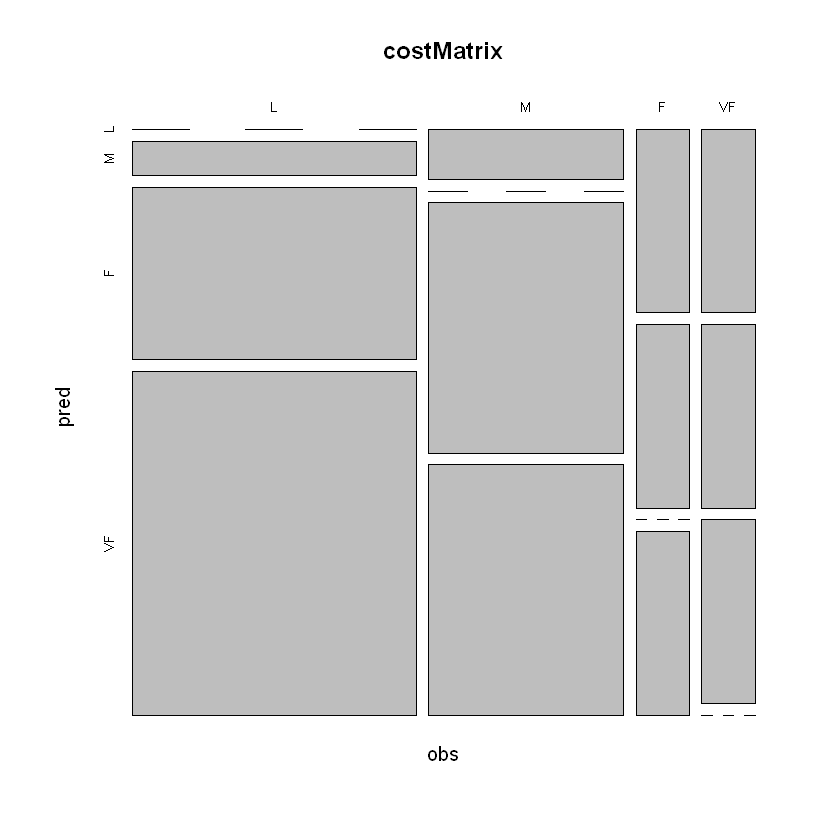

In [31]:
mosaicplot(t(costMatrix),xlab = "obs",ylab="pred",main="costMatrix")

In [11]:
### Create a cost function
cost <- function(pred, obs)
{
  isNA <- is.na(pred)
  if(!all(isNA))
  {
    pred <- pred[!isNA]
    obs <- obs[!isNA]
    
    cost <- ifelse(pred == obs, 0, 1)
    if(any(pred == "VF" & obs == "L")) cost[pred == "L" & obs == "VF"] <- 10
    if(any(pred == "F" & obs == "L")) cost[pred == "F" & obs == "L"] <- 5
    if(any(pred == "F" & obs == "M")) cost[pred == "F" & obs == "M"] <- 5
    if(any(pred == "VF" & obs == "M")) cost[pred == "VF" & obs == "M"] <- 5
    out <- mean(cost)
  } else out <- NA
  out
}

### Make a summary function that can be used with caret's train() function
costSummary <- function (data, lev = NULL, model = NULL)
{
  if (is.character(data$obs))  data$obs <- factor(data$obs, levels = lev)
  c(postResample(data[, "pred"], data[, "obs"]),
    Cost = cost(data[, "pred"], data[, "obs"]))
}

### Create a control object for the models
ctrl <- trainControl(method = "repeatedcv", 
                     repeats = 5,
                     summaryFunction = costSummary)

In [12]:
library(doMC)
registerDoMC()
# https://cran.r-project.org/web/packages/doMC/vignettes/gettingstartedMC.pdf

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [13]:
set.seed(857)
fit_cart <- train(x=trn[,predictors],
                 y=trn$Class,method="rpart",metric="Cost",maximize=F,
                 tuneLength=20,trControl=ctrl)
fit_cart

CART 

3467 samples
   7 predictor
   4 classes: 'VF', 'F', 'M', 'L' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 3120, 3120, 3120, 3120, 3120, 3120, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa      Cost     
  0.003140950  0.7759920  0.6335893  0.4974085
  0.003533569  0.7714334  0.6247628  0.5116708
  0.003631724  0.7703398  0.6224321  0.5173861
  0.003729878  0.7694162  0.6206732  0.5220117
  0.004122497  0.7675125  0.6164861  0.5333652
  0.004711425  0.7641114  0.6099480  0.5496917
  0.005300353  0.7630147  0.6072727  0.5563256
  0.007067138  0.7512484  0.5869460  0.5800858
  0.007656066  0.7432861  0.5740573  0.5928929
  0.007950530  0.7350387  0.5608438  0.6036717
  0.008833922  0.7258063  0.5451929  0.6230729
  0.009422850  0.7212503  0.5366356  0.6382455
  0.009717314  0.7206739  0.5356619  0.6411254
  0.011189635  0.7160586  0.5241189  0.6757306
  0.014134276  0.7095957  0.5145406  

In [14]:
# str(confusionMatrix(reference = trn$Class,data = predict(fit_cart,trn[,predictors])))
cm_cart <- confusionMatrix(reference = trn$Class,data = predict(fit_cart,trn[,predictors]))

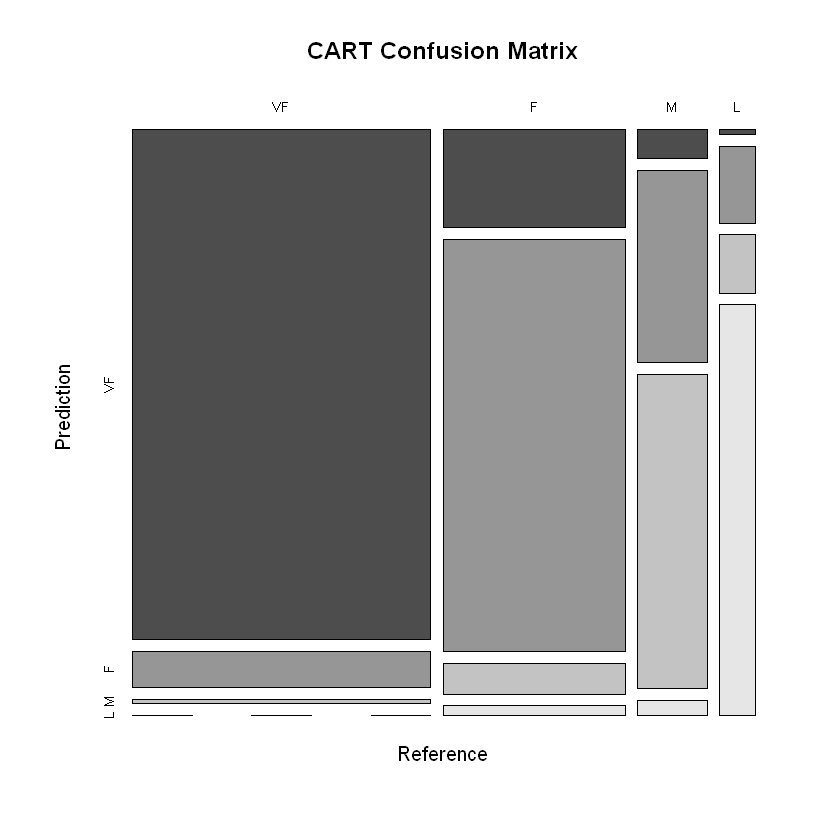

In [23]:
mosaicplot(t(cm_cart$table),color = T,main="CART Confusion Matrix")